# How-to use a RooFit PDF

This demonstrates the use of the wrapper function `convert_rf_pdf`, which converts a fitted RooAbsPdf into a callable that our package can use.

To run this example, you need to install ROOT. The easiest way is to use conda (or better mamba). You can install it like this:

`mamba install -c conda-forge root`

We make a dummy RooFit model.

In [1]:
import ROOT as R
import ROOT.RooFit as RF

# observable
mass = R.RooRealVar("m", "m", 5000, 5800)

# gaussian
mean = R.RooRealVar("mu", "mu", 5350, 5300, 5400)
sigma = R.RooRealVar("sg", "sg", 25, 1e-3, 100)
spdf = R.RooGaussian("sig", "sig", mass, mean, sigma)

# exponential
slope = R.RooRealVar("lb", "lb", -0.002, -0.01, 0)
bpdf = R.RooExponential("bkg", "bkg", mass, slope)

# total
sy = R.RooRealVar("sy", "sy", 1000, 0, 10000)
by = R.RooRealVar("by", "by", 2000, 0, 10000)
pdf = R.RooAddPdf("pdf", "pdf", (spdf, bpdf), (sy, by))

We plot the dummy model using RooFit commands.

[#1] INFO:Plotting -- RooAbsPdf::plotOn(pdf) directly selected PDF components: (bkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(pdf) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(pdf) directly selected PDF components: (sig)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(pdf) indirectly selected PDF components: ()


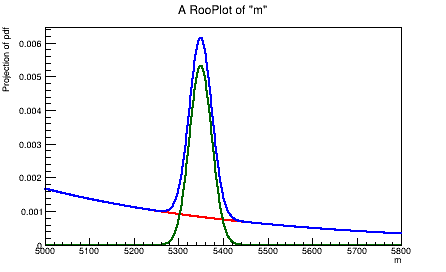

In [2]:
c = R.TCanvas('c','c',450,300)
pl = mass.frame(RF.Bins(800))
pdf.plotOn(
    pl,
    RF.Normalization(1, R.RooAbsReal.NumEvent),
    RF.Precision(-1),
    RF.Components("bkg"),
    RF.LineColor(R.kRed),
    RF.LineStyle(2),
    RF.LineWidth(2)
)
pdf.plotOn(
    pl,
    RF.Normalization(1, R.RooAbsReal.NumEvent),
    RF.Precision(-1),
    RF.Components("sig"),
    RF.LineColor(R.kGreen + 3),
    RF.LineWidth(2)
)
pdf.plotOn(pl, RF.Normalization(1, R.RooAbsReal.NumEvent), RF.Precision(-1), RF.LineWidth(2))
pl.Draw()
c.Draw()

Now convert the RooFit PDF object into a simple Python callable.

In [3]:
from sweights.util import convert_rf_pdf

spdf_py = convert_rf_pdf(spdf, mass)
bpdf_py = convert_rf_pdf(bpdf, mass)
pdf_py = convert_rf_pdf(pdf, mass)

You can now use these pdfs in the `SWeight` and `Cow` objects. We just draw them with matplotlib here, to show that the pdfs work.

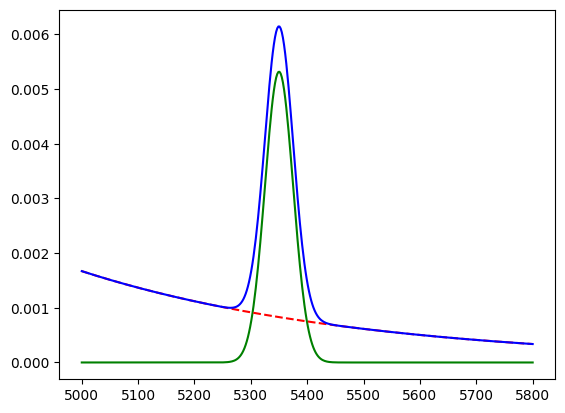

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# we normalize the yields to match the way RooFit plots the pdf.
fs = sy.getVal() / (sy.getVal() + by.getVal())
fb = by.getVal() / (sy.getVal() + by.getVal())

x = np.linspace(mass.getMin(), mass.getMax(), 400)
plt.plot(x, fs * spdf_py(x), "g-")
plt.plot(x, fb * bpdf_py(x), "r--")
plt.plot(x, pdf_py(x), "b-");

We get the same result.

If more speed is required, for example, because the pdfs are evaluated on huge datasets, one can use an approximate conversion of the exact PDF into a spline interpolator with the keyword `npoints`. It is up to the user to choose a sufficient number of points to obtain a good the approximation. The sharper the features of the pdf, the more points should be used.

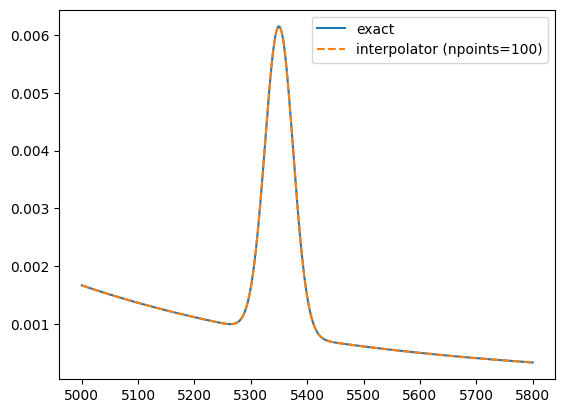

In [5]:
pdf_py_spline_100 = convert_rf_pdf(pdf, mass, npoints=100)
pdf_py_spline_1000 = convert_rf_pdf(pdf, mass, npoints=1000)

plt.plot(x, pdf_py(x), label="exact")
plt.plot(x, pdf_py_spline_100(x), ls="--", label="interpolator (npoints=100)")
plt.legend();

Increasing the number of points by one order of magnitude makes the interpolator more accurate by two orders of magnitude in this case.

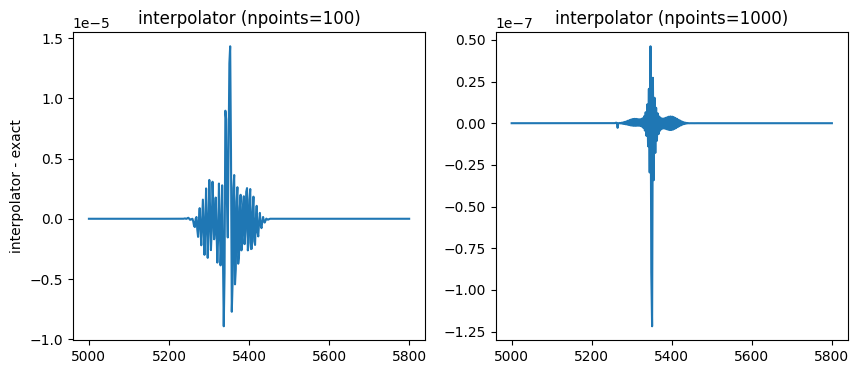

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].set_title("interpolator (npoints=100)")
ax[0].plot(x, pdf_py(x) - pdf_py_spline_100(x))
ax[0].set_ylabel("interpolator - exact")
ax[1].set_title("interpolator (npoints=1000)")
ax[1].plot(x, pdf_py(x) - pdf_py_spline_1000(x));

The interpolator is about a factor of 10 faster to evaluate. The evaluation time increases with the number of points, but only logarithmically.

In [7]:
%timeit pdf_py(x)

120 μs ± 11.4 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%timeit pdf_py_spline_100(x)

10.1 μs ± 1.04 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [9]:
%timeit pdf_py_spline_1000(x)

13.5 μs ± 633 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
